# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working medel's existing architecture and learned for our own problems.

There are two main benifits:
1. Can leverage an exisiting neural newtwork architecure proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterens on similar data to our own, then we can adapt those patterns to our own data.

In [5]:
# Are you using a GPU
!nvidia-smi

Wed Oct 13 20:19:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [6]:
# Get data (10% of 10 food classes from Food101)

import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2021-10-13 20:19:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   169MB/s    in 1.0s    

2021-10-13 20:19:23 (169 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [7]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "10_food_classes_10_percent".
There are 10 directories and 0 images in "10_food_classes_10_percent/train".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/fried_rice".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/ramen".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/ice_cream".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_wings".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/steak".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_curry".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/sushi".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/pizza".
There are 0 directories and 75 images in "10_food_classes_10_percent/train/grilled_salmon".
There are 0 directories and 75 images in "10_food_classes_10_percent/tra

## Creating data loaders (preparing the data)

We will use the `ImageDataGenerator` class to load our images in batches.

In [22]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/225.)
test_datagen = ImageDataGenerator(rescale=1/225.)

print('Training image:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size= BATCH_SIZE,
                                                         class_mode='categorical')

print('Tesing image:')
test_data = test_datagen.flow_from_directory(train_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode='categorical')


Training image:
Found 750 images belonging to 10 classes.
Tesing image:
Found 750 images belonging to 10 classes.


## Setting up callbacks (things to run whilest our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [23]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback


## Creating models using TensorFlow Hub

In the past we have used TensorFlow to create our own models layer by layer from similar

Now we are going to do a similar process, except that 


Browsing the tf hub page and sorting for image classification, we found the following feature vector extractor.
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [24]:
# Let's compare models

resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [25]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [28]:
def create_model(model_url, num_classes=10):
  
  """
  Takes a TensorFlow Hub URL and creates a Kreas Sequential model with it.

  Args:
     model_url (str): A TensorFlow Hub feature extraction URL.
     num_classes (int): Number of output neurons in the output layer,
     should be equal to number of target calsses, default 10.

     Returns:
        An uncompiled
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extractor_layer',
                                           input_shape=IMAGE_SHAPE  + (3, )) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')                               
  ])

  return model

### Creating and tesing ResNet TensorFlow Hub Feature Extraction model

In [29]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [31]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [32]:
# Compile our model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [33]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20211013-210604
Epoch 1/5
24/24 [==============================] - 47s 539ms/step - loss: 1.8941 - accuracy: 0.3627 - val_loss: 1.0801 - val_accuracy: 0.6587
Epoch 2/5
24/24 [==============================] - 10s 430ms/step - loss: 0.9006 - accuracy: 0.7133 - val_loss: 0.6720 - val_accuracy: 0.7987
Epoch 3/5
24/24 [==============================] - 10s 428ms/step - loss: 0.6221 - accuracy: 0.8240 - val_loss: 0.5064 - val_accuracy: 0.8693
Epoch 4/5
24/24 [==============================] - 10s 427ms/step - loss: 0.4754 - accuracy: 0.8773 - val_loss: 0.3895 - val_accuracy: 0.9147
Epoch 5/5
24/24 [==============================] - 10s 428ms/step - loss: 0.3812 - accuracy: 0.9133 - val_loss: 0.3209 - val_accuracy: 0.9387


Wow!

That. Is incredible, Transfer Learning feature extractor
model out performed ALL of the previous models we build by hand...(substaintially) and with only 10% of the training examples.

In [39]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called 'helper.py' and import it when you need it
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
     Returns separate loos curves for training and validation metrics.

     Args:
       history: TensorFlow History object

     Returns:  
  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


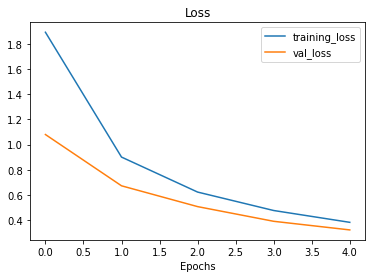

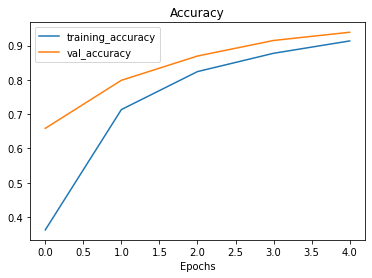

In [40]:
plot_loss_curves(resnet_history)

### Creating and tesing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [42]:
# Create EfficientNetB0 extractor model

efficientnet_model = create_model(model_url=efficientnet_url,
                                   num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

# Fit the model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20211013-213755
Epoch 1/5
24/24 [==============================] - 24s 558ms/step - loss: 1.8276 - accuracy: 0.4413 - val_loss: 1.2779 - val_accuracy: 0.7333
Epoch 2/5
24/24 [==============================] - 9s 389ms/step - loss: 1.0638 - accuracy: 0.7693 - val_loss: 0.8538 - val_accuracy: 0.8213
Epoch 3/5
24/24 [==============================] - 9s 388ms/step - loss: 0.7711 - accuracy: 0.8333 - val_loss: 0.6665 - val_accuracy: 0.8640
Epoch 4/5
24/24 [==============================] - 9s 386ms/step - loss: 0.6275 - accuracy: 0.8627 - val_loss: 0.5565 - val_accuracy: 0.8880
Epoch 5/5
24/24 [==============================] - 9s 394ms/step - loss: 0.5349 - accuracy: 0.8813 - val_loss: 0.4783 - val_accuracy: 0.9027


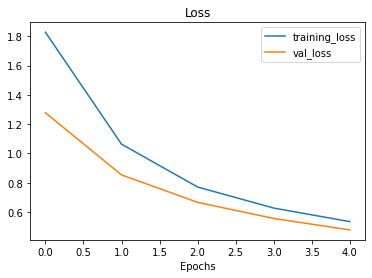

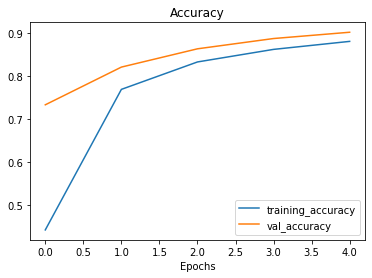

In [43]:
plot_loss_curves(efficientnet_history)

In [44]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [46]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [53]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Differenet types of Transfer Learning

* **"AS is"** transfer learning - using an existing model with no changes what so ever (e.g. )
* **"Feature Extraction"** tansfer learning - use the prelearned patterns of an existing model
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an exising model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TengsorBoard.dev, your experiments are public. so if you are running private experiments (things you don't want other ot see) do not upload them to TensorBoard.dev

In [49]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2021-10-13 22:04:46.733511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 22:04:46.758894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 22:04:46.759448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

Our TensorBoard experiments are uploaded publically here
https://tensorboard.dev/experiment/sN78QpszRcaEOFA5AogXZA/


In [51]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-10-13 22:10:18.333199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 22:10:18.341896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 22:10:18.342420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/sN78QpszRcaEOFA5AogXZA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   sN78QpszRcaEOFA5AogXZA
	Created              2021-10-13 22:05:57 (4 minutes ago)
	Up

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id sN78QpszRcaEOFA5AogXZA